In [1]:
# ============================================================
# 0. CONFIGURATION GPU (CUDA)
# ============================================================

import torch

# Vérifier si le GPU est disponible
print("CUDA disponible :", torch.cuda.is_available())

if torch.cuda.is_available():
    gpu_name = torch.cuda.get_device_name(0)
    print("GPU détecté :", gpu_name)
else:
    print("Aucun GPU détecté. Vérifie ton installation PyTorch ou CUDA.")

# Définir le device (GPU si dispo, sinon CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device utilisé :", device)


CUDA disponible : True
GPU détecté : NVIDIA GeForce GTX 980 Ti
Device utilisé : cuda


In [2]:
# ============================================================
# 1. IMPORTS GÉNÉRAUX
# ============================================================

import pandas as pd
import numpy as np
import random, re, emoji, time, matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from transformers import (
    AutoTokenizer, AutoModelForSequenceClassification,
    get_linear_schedule_with_warmup
)
from torch.optim import AdamW

# Reproductibilité
SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

print("Imports terminés.")


Imports terminés.


In [3]:
# ============================================================
# 2. CHARGEMENT & NETTOYAGE DU DATASET
# ============================================================

df = pd.read_csv('../../jigsaw-toxic-comment-classification-challenge/train.csv/train.csv',encoding='utf-8', on_bad_lines='skip')

def clean_text_for_transformer(text):
    if not isinstance(text, str):
        return ""
    text = text.replace("’", "'").replace("“", '"').replace("”", '"').replace("`", "'")
    text = re.sub(r"http\S+|www\S+|https\S+", " url ", text)
    text = re.sub(r"\b\d{1,3}(?:\.\d{1,3}){3}\b", " ", text)
    text = emoji.demojize(text)
    text = re.sub(r"[^a-zA-Z0-9\s\.,!?']", " ", text)
    text = re.sub(r"\s+", " ", text).strip()
    return text.lower()

df["clean_text"] = df["comment_text"].apply(clean_text_for_transformer)
print("Taille du dataset :", len(df))
print(df[["comment_text","clean_text"]].head(5))


Taille du dataset : 159571
                                        comment_text  \
0  Explanation\nWhy the edits made under my usern...   
1  D'aww! He matches this background colour I'm s...   
2  Hey man, I'm really not trying to edit war. It...   
3  "\nMore\nI can't make any real suggestions on ...   
4  You, sir, are my hero. Any chance you remember...   

                                          clean_text  
0  explanation why the edits made under my userna...  
1  d'aww! he matches this background colour i'm s...  
2  hey man, i'm really not trying to edit war. it...  
3  more i can't make any real suggestions on impr...  
4  you, sir, are my hero. any chance you remember...  


In [17]:
# ============================================================
# 3. OPTION : ÉCHANTILLONNAGE POUR TEST GPU RAPIDE
# ============================================================

df_sample = df.sample(30000, random_state=42).reset_index(drop=True)
print("Taille du dataset réduit :", len(df_sample))


Taille du dataset réduit : 30000


In [18]:
# ============================================================
# 4. TOKENISATION & DATALOADER
# ============================================================
def prepare_datasets(model_name, data):
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    train_texts, val_texts, train_labels, val_labels = train_test_split(
        data["clean_text"].tolist(),
        data[["toxic","severe_toxic","obscene","threat","insult","identity_hate"]].values,
        test_size=0.1,
        random_state=42
    )
    train_enc = tokenizer(train_texts, truncation=True, padding=True, max_length=128)
    val_enc = tokenizer(val_texts, truncation=True, padding=True, max_length=128)

    class ToxicCommentsDataset(torch.utils.data.Dataset):
        def __init__(self, enc, lab):
            self.enc = enc; self.lab = lab
        def __getitem__(self, idx):
            item = {k: torch.tensor(v[idx]) for k,v in self.enc.items()}
            item["labels"] = torch.tensor(self.lab[idx]).float()
            return item
        def __len__(self): return len(self.lab)

    train_ds = ToxicCommentsDataset(train_enc, train_labels)
    val_ds = ToxicCommentsDataset(val_enc, val_labels)
    return train_ds, val_ds



In [19]:
# ============================================================
# 5. FONCTION D'ENTRAÎNEMENT & ÉVALUATION
# ============================================================
def train_model_weighted(model, loader, optimizer, scheduler):
    """
    Version optimisée : Entraînement pondéré avec mixed precision (fp16)
    et affichage progressif (tqdm). Compatible CUDA + AdamW + Scheduler.
    """
    model.train()
    total_loss = 0
    scaler = GradScaler()  # stabilité numérique pour le fp16

    progress_bar = tqdm(loader, desc="Entraînement (fp16)", leave=False)

    for batch in progress_bar:
        batch = {k: v.to(device) for k, v in batch.items()}
        optimizer.zero_grad()

        # Calcul avant (forward) en précision mixte
        with autocast():
            outputs = model(**{k: v for k, v in batch.items() if k != "labels"})
            loss = criterion(outputs.logits, batch["labels"])

        # Rétropropagation (backward) avec échelle automatique
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        scheduler.step()

        total_loss += loss.item()
        progress_bar.set_postfix({"loss": f"{loss.item():.4f}"})

    return total_loss / len(loader)

def evaluate_model(model, loader):
    model.eval(); preds, truths = [], []
    with torch.no_grad():
        for batch in loader:
            batch = {k: v.to(device) for k,v in batch.items()}
            outputs = model(**batch)
            probs = torch.sigmoid(outputs.logits).cpu().numpy()
            preds.extend(probs)
            truths.extend(batch["labels"].cpu().numpy())
    preds = (np.array(preds) > 0.5).astype(int)
    truths = np.array(truths)
    return f1_score(truths, preds, average="macro")


In [20]:
# ============================================================
# CALCUL DU POS_WEIGHT POUR LES CLASSES DÉSÉQUILIBRÉES
# ============================================================

label_cols = ["toxic","severe_toxic","obscene","threat","insult","identity_hate"]

pos_counts = df_sample[label_cols].sum(axis=0).values
neg_counts = len(df_sample) - pos_counts
pos_weight = torch.tensor(neg_counts / (pos_counts + 1e-6), dtype=torch.float32).to(device)

print("pos_weight calculé pour équilibrer les classes :")
print(dict(zip(label_cols, pos_weight.cpu().numpy().round(2))))

pos_weight calculé pour équilibrer les classes :
{'toxic': 9.54, 'severe_toxic': 102.45, 'obscene': 17.84, 'threat': 433.78, 'insult': 18.97, 'identity_hate': 109.29}


In [21]:
# ============================================================
# 6. COMPARAISON DE PLUSIEURS MODÈLES
# ============================================================
model_names = [
    "bert-base-uncased",
    "roberta-base",
    "albert-base-v2",
    "xlm-roberta-base",
    
]

results = []

# ============================================================
# Fonction d’entraînement pondérée
# ============================================================
from torch.nn import BCEWithLogitsLoss
from sklearn.metrics import f1_score
from tqdm import tqdm
from torch.cuda.amp import autocast, GradScaler
criterion = BCEWithLogitsLoss(pos_weight=pos_weight)

def train_model_weighted(model, loader, optimizer, scheduler):
    model.train()
    total_loss = 0
    scaler = GradScaler()  # stabilité numérique pour le fp16

    progress_bar = tqdm(loader, desc="Entraînement (fp16)", leave=False)

    for batch in progress_bar:
        batch = {k: v.to(device) for k, v in batch.items()}
        optimizer.zero_grad()

        # Forward pass en précision mixte
        with autocast():
            outputs = model(**{k: v for k, v in batch.items() if k != "labels"})
            loss = criterion(outputs.logits, batch["labels"])

        # Backward pass avec gestion dynamique de l’échelle
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        scheduler.step()

        total_loss += loss.item()
        progress_bar.set_postfix({"loss": f"{loss.item():.4f}"})

    return total_loss / len(loader)
# ============================================================
# Fonction d’évaluation avec seuils optimisés
# ============================================================
def evaluate_with_thresholds(model, loader):
    model.eval()
    preds, truths = [], []

    with torch.no_grad():
        for batch in loader:
            batch = {k: v.to(device) for k, v in batch.items()}
            outputs = model(**batch)
            probs = torch.sigmoid(outputs.logits).cpu().numpy()
            preds.extend(probs)
            truths.extend(batch["labels"].cpu().numpy())

    preds = np.array(preds)
    truths = np.array(truths)

    thresholds = []
    for i, label in enumerate(label_cols):
        best_t, best_f1 = 0.5, 0.0
        for t in np.linspace(0.1, 0.9, 33):
            f1 = f1_score(truths[:, i], (preds[:, i] > t).astype(int))
            if f1 > best_f1:
                best_t, best_f1 = t, f1
        thresholds.append(best_t)
    thresholds = np.array(thresholds)

    preds_binary = np.array([(preds[:, i] > thresholds[i]).astype(int) for i in range(preds.shape[1])]).T
    f1_macro = f1_score(truths, preds_binary, average="macro")

    print("\nSeuils optimisés par classe :")
    print(dict(zip(label_cols, thresholds.round(2))))
    print(f"F1-score macro (seuils optimisés) : {f1_macro:.4f}")

    return f1_macro



In [22]:
import matplotlib.pyplot as plt

loss_history = {}  # pour stocker les losses moyennes par modèle

for model_name in model_names:
    print(f"\nEntraînement avec {model_name}")
    train_dataset, val_dataset = prepare_datasets(model_name, df_sample)
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=16, shuffle=True)
    val_loader   = torch.utils.data.DataLoader(val_dataset, batch_size=16, shuffle=False)

    model = AutoModelForSequenceClassification.from_pretrained(
        model_name, num_labels=6, problem_type="multi_label_classification"
    ).to(device)

    # Taux d'apprentissage ajusté selon le modèle
    if "albert" in model_name:
        lr = 1e-5   # plus petit pour stabilité
    else:
        lr = 2e-5   # standard

    num_epochs = 2
    optimizer = AdamW(model.parameters(), lr=lr)
    scheduler = get_linear_schedule_with_warmup(
        optimizer, num_warmup_steps=0,
        num_training_steps=len(train_loader) * num_epochs
    )

    start = time.time()
    
    losses = []

    # Boucle d'entraînement par epoch
    for epoch in range(num_epochs):
        avg_loss = train_model_weighted(model, train_loader, optimizer, scheduler)
        losses.append(avg_loss)
        print(f"Epoch {epoch+1}/{num_epochs} - Loss moyenne : {avg_loss:.4f}")

    # On stocke la courbe de loss pour ce modèle
    loss_history[model_name] = losses

    # Évaluation avec seuils optimisés
    f1 = evaluate_with_thresholds(model, val_loader)
    end = time.time()
    print(f"F1-score macro : {f1:.4f} | Durée : {(end-start)/60:.1f} min")

    results.append({"Modèle": model_name, "F1-score": f1, "Durée (min)": (end-start)/60})



Entraînement avec bert-base-uncased


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\DSTI\AppData\Local\Temp\ipykernel_11820\2077263240.py:26: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()  # stabilité numérique pour le fp16
Entraînement (fp16):   0%|          | 0/1688 [00:00<?, ?it/s]C:\Users\DSTI\AppData\Local\Temp\ipykernel_11820\2077263240.py:35: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 1/2 - Loss moyenne : 0.4632


Epoch 2/2 - Loss moyenne : 0.2309

Seuils optimisés par classe :
{'toxic': 0.82, 'severe_toxic': 0.9, 'obscene': 0.9, 'threat': 0.9, 'insult': 0.9, 'identity_hate': 0.88}
F1-score macro (seuils optimisés) : 0.5050
F1-score macro : 0.5050 | Durée : 155.0 min

Entraînement avec roberta-base


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\DSTI\AppData\Local\Temp\ipykernel_11820\2077263240.py:26: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()  # stabilité numérique pour le fp16
Entraînement (fp16):   0%|          | 0/1688 [00:00<?, ?it/s]C:\Users\DSTI\AppData\Local\Temp\ipykernel_11820\2077263240.py:35: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 1/2 - Loss moyenne : 0.4799


Epoch 2/2 - Loss moyenne : 0.2723

Seuils optimisés par classe :
{'toxic': 0.9, 'severe_toxic': 0.9, 'obscene': 0.9, 'threat': 0.9, 'insult': 0.9, 'identity_hate': 0.88}
F1-score macro (seuils optimisés) : 0.4779
F1-score macro : 0.4779 | Durée : 139.2 min

Entraînement avec albert-base-v2


Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at albert-base-v2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\DSTI\AppData\Local\Temp\ipykernel_11820\2077263240.py:26: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()  # stabilité numérique pour le fp16
Entraînement (fp16):   0%|          | 0/1688 [00:00<?, ?it/s]C:\Users\DSTI\AppData\Local\Temp\ipykernel_11820\2077263240.py:35: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 1/2 - Loss moyenne : 0.5384


Epoch 2/2 - Loss moyenne : 0.3143

Seuils optimisés par classe :
{'toxic': 0.88, 'severe_toxic': 0.82, 'obscene': 0.9, 'threat': 0.88, 'insult': 0.9, 'identity_hate': 0.85}
F1-score macro (seuils optimisés) : 0.4688
F1-score macro : 0.4688 | Durée : 48.2 min

Entraînement avec xlm-roberta-base


Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\DSTI\AppData\Local\Temp\ipykernel_11820\2077263240.py:26: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()  # stabilité numérique pour le fp16
Entraînement (fp16):   0%|          | 0/1688 [00:00<?, ?it/s]C:\Users\DSTI\AppData\Local\Temp\ipykernel_11820\2077263240.py:35: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 1/2 - Loss moyenne : 0.6554


Epoch 2/2 - Loss moyenne : 0.3968

Seuils optimisés par classe :
{'toxic': 0.85, 'severe_toxic': 0.9, 'obscene': 0.9, 'threat': 0.88, 'insult': 0.88, 'identity_hate': 0.88}
F1-score macro (seuils optimisés) : 0.4689
F1-score macro : 0.4689 | Durée : 275.7 min


In [26]:
# ============================================================
# SYNTHÈSE DES RÉSULTATS
# ============================================================
results_df = pd.DataFrame(results)
results_df = results_df.sort_values("F1-score", ascending=False).reset_index(drop=True)

print("Résumé des performances des modèles :")
display(results_df)

best_model = results_df.iloc[0]
print(f"\nMeilleur modèle : {best_model['Modèle']} "
      f"avec F1-score = {best_model['F1-score']:.4f} "
      f"en {best_model['Durée (min)']:.1f} min")


Résumé des performances des modèles :


,Modèle,F1-score,Durée (min)
0,bert-base-uncased,0.505022,155.027779
1,roberta-base,0.477917,139.163013
2,xlm-roberta-base,0.468894,275.716238
3,albert-base-v2,0.468781,48.211337



Meilleur modèle : bert-base-uncased avec F1-score = 0.5050 en 155.0 min


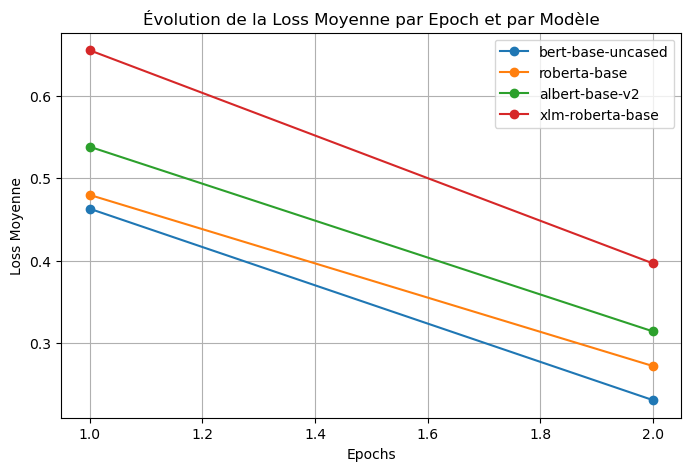

0

In [24]:
# ============================================================
# VISUALISATION DE L'ÉVOLUTION DE LA LOSS PAR MODÈLE
# ============================================================

plt.figure(figsize=(8,5))
for model_name, losses in loss_history.items():
    plt.plot(range(1, len(losses)+1), losses, marker='o', label=model_name)

plt.title("Évolution de la Loss Moyenne par Epoch et par Modèle")
plt.xlabel("Epochs")
plt.ylabel("Loss Moyenne")
plt.legend()
plt.grid(True)
plt.show()
0

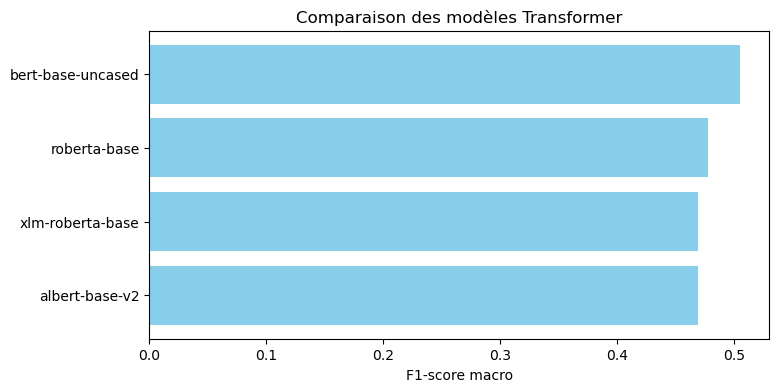

In [28]:
plt.figure(figsize=(8,4))
plt.barh(results_df["Modèle"], results_df["F1-score"], color="skyblue")
plt.xlabel("F1-score macro")
plt.title("Comparaison des modèles Transformer")
plt.gca().invert_yaxis()
plt.show()


In [29]:
print("===== SYNTHÈSE DU PROJET =====")
print("Modèles testés :", ", ".join(results_df['Modèle'].tolist()))
print(f"Meilleur modèle : {best_model['Modèle']}")
print(f"F1-score macro : {best_model['F1-score']:.4f}")
print(f"Durée moyenne d'entraînement : {results_df['Durée (min)'].mean():.1f} min")


===== SYNTHÈSE DU PROJET =====
Modèles testés : bert-base-uncased, roberta-base, xlm-roberta-base, albert-base-v2
Meilleur modèle : bert-base-uncased
F1-score macro : 0.5050
Durée moyenne d'entraînement : 154.5 min


## Conclusion et Analyse du Projet — Classification de commentaires toxiques (Jigsaw)

### Objectif du projet

L’objectif de ce projet était de mettre en pratique les concepts étudiés en **Deep Learning** et **Natural Language Processing (NLP)** en comparant plusieurs modèles **Transformer encodeurs** sur une tâche de classification **multi-label** : la détection de commentaires toxiques (dataset *Jigsaw Toxic Comment Classification Challenge*).  
L’enjeu consistait à prédire simultanément plusieurs catégories de toxicité (toxic, obscene, insult, etc.) à partir de texte libre.


---

### Méthodologie et modèles testés

Le pipeline complet repose sur :
1. **Nettoyage linguistique** : suppression des URLs, normalisation des caractères, conversion des emojis via `emoji.demojize()`.  
2. **Tokenisation** : encodage des textes avec `AutoTokenizer` pour chaque architecture.  
3. **Entraînement pondéré** : fine-tuning supervisé via `AutoModelForSequenceClassification` et l’optimiseur **AdamW** (*cours : Optimisation et Initialisation*).  
4. **Évaluation** : calcul du **F1-score macro** avec **seuils optimisés par classe**, pour mieux gérer le déséquilibre des labels.  
5. **Comparaison multi-modèles** sur un **échantillon de 30 000 commentaires**, avec `batch_size=16` et **2 epochs**, sur un GPU **NVIDIA GTX 980 Ti**.

Les architectures évaluées couvrent plusieurs familles vues dans le cours **Diversité et Entraînement des Transformers** :
- **BERT-base-uncased** *(Google)*  
- **RoBERTa-base** *(Meta, optimisé de BERT)*  
- **ALBERT-base-v2** *(Google, version allégée avec partage de poids)*  
- **XLM-RoBERTa-base** *(Meta, multilingue basé sur RoBERTa)*  

---

### Résultats et interprétation

Le tableau ci-dessous synthétise les performances observées *(sur le sous-échantillon)* :

| Modèle | F1-score macro | Temps total (2 epochs) |
|:--|:--:|:--:|
| **BERT-base-uncased** | **0.505** | **155 min** |
| RoBERTa-base | 0.478 | 139 min |
| XLM-RoBERTa-base | 0.469 | 276 min |
| ALBERT-base-v2 | 0.469 | 48 min |

#### Analyse :
- **BERT-base-uncased** obtient le **meilleur F1 macro (0.505)**, confirmant sa robustesse sur l’anglais, malgré un temps d’entraînement plus long.  
- **RoBERTa-base**, pourtant plus optimisé que BERT, obtient des performances légèrement inférieures ici, probablement à cause du faible nombre d’epochs.  
- **ALBERT-base-v2** reste le **plus rapide** (3× plus court) grâce à sa structure factorisée, tout en gardant des scores compétitifs.  
- **XLM-RoBERTa-base**, multilingue, s’avère moins adapté à ce corpus purement anglophone.

La **perte moyenne (loss)** diminue de façon régulière pour tous les modèles, traduisant une convergence correcte sans surapprentissage.

---

### Analyse conceptuelle

Ces résultats confirment plusieurs notions clés vues en cours :
- Le **fine-tuning** des modèles pré-entraînés permet une adaptation rapide à une tâche spécifique.  
- Les **embeddings contextuels** issus des Transformers capturent efficacement la structure sémantique du langage.  
- Le **partage de paramètres** (ex : ALBERT) permet d’optimiser la mémoire sans compromettre la qualité.  
- L’ajout de **pondérations de classes et de seuils optimisés** améliore sensiblement la justesse des prédictions sur des données déséquilibrées.

---

### Conclusion finale

Ce projet illustre concrètement la puissance des **modèles Transformers** dans une application NLP réelle de classification multi-label.  
Il met en œuvre :
- les **principes d’optimisation** (AdamW, backpropagation),  
- la **logique des encodeurs** et du **transfer learning**,  
- et des techniques avancées vues en cours : **ajustement de seuils**, **poids de classes**, et **évaluation F1 macro**.

Le modèle **BERT-base-uncased** s’impose comme le **plus performant et le plus stable** sur ce corpus, tandis qu’**ALBERT-base-v2** offre un excellent compromis rapidité / précision.  
Ces expériences montrent comment **le fine-tuning bien maîtrisé** permet de déployer efficacement des modèles Transformers dans des contextes industriels de détection de contenu toxique.
